Total Images = 130
Suspect images = 50
Threshold = 0.80
matched images = 40


In [1]:
# !pip install torch transformers pillow scikit-learn pathlib matplotlib pandas ipywidgets

# Imports and Setup

In [2]:
# ============================================================================
# CELL 1: IMPORTS AND SETUP
# ============================================================================

import torch
import os
import shutil
from datetime import datetime
import json
import numpy as np
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from sklearn.metrics.pairwise import cosine_similarity
from pathlib import Path
import logging
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

print("✓ All modules imported successfully")

✓ All modules imported successfully


# Configuration

In [3]:
# ============================================================================
# CELL 2: CONFIGURATION
# ============================================================================

# CONFIGURATION - MODIFY THESE PATHS FOR YOUR CASE
CONFIG = {
    'reference_folder': '../datasets/images/face/reference_images',      # Folder with 3-4 reference images
    'gallery_folder': '../datasets/images/face/gallery',          # Folder with gallery images to search
    'output_folder': '../datasets/images/face/matched_images',          # Output folder for matches
    'similarity_threshold': 0.80,                 # Similarity threshold (0.6-0.8 typical)
    'max_matches': None,                          # Maximum matches to find (None = unlimited)
    'model_name': 'openai/clip-vit-base-patch32', # CLIP model to use
    'show_progress': True,                        # Show progress bars
    'create_visualizations': True                 # Create match visualizations
}

print("Configuration loaded:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

import os
os.getcwd()

Configuration loaded:
  reference_folder: ../datasets/images/face/reference_images
  gallery_folder: ../datasets/images/face/gallery
  output_folder: ../datasets/images/face/matched_images
  similarity_threshold: 0.8
  max_matches: None
  model_name: openai/clip-vit-base-patch32
  show_progress: True
  create_visualizations: True


'C:\\Users\\scott\\OneDrive\\Documents\\DevBox\\Python\\AI_Projects\\ai_cyberforensics\\face_detection'

# Module: ForensicImageProcessor

In [4]:
# ============================================================================
# CELL 3: CORE CLASSES AND FUNCTIONS
# ============================================================================

class ForensicImageProcessor:
    """Core image processing functionality"""
    
    def __init__(self, model_name="openai/clip-vit-base-patch32"):
        self.model_name = model_name
        self.model = None
        self.processor = None
        
    def load_model(self):
        """Load CLIP model and processor"""
        print("Loading CLIP model...")
        self.model = CLIPModel.from_pretrained(self.model_name)
        self.processor = CLIPProcessor.from_pretrained(self.model_name)
        self.model.eval()
        print("✓ CLIP model loaded successfully")
        
    def generate_embedding(self, image_path):
        """Generate CLIP embedding for a single image"""
        try:
            image = Image.open(image_path).convert('RGB')
            inputs = self.processor(images=image, return_tensors="pt")
            
            with torch.no_grad():
                embeddings = self.model.get_image_features(**inputs)
                embeddings = embeddings / embeddings.norm(dim=-1, keepdim=True)
            
            return embeddings.numpy().flatten()
            
        except Exception as e:
            print(f"Error processing {image_path}: {str(e)}")
            return None

# Module: ReferenceManager

In [5]:
class ReferenceManager:
    """Manages reference suspect images"""
    
    def __init__(self, processor):
        self.processor = processor
        self.embeddings = []
        self.image_paths = []
        self.valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif'}
        
    def load_references(self, reference_folder):
        """Load and process 3-4 reference images"""
        print(f"Loading reference images from: {reference_folder}")
        
        # Find reference files
        reference_files = []
        for file_path in Path(reference_folder).iterdir():
            if file_path.suffix.lower() in self.valid_extensions:
                reference_files.append(file_path)
        
        if len(reference_files) < 3:
            raise ValueError(f"Need at least 3 reference images. Found {len(reference_files)}")
        
        if len(reference_files) > 4:
            print(f"Found {len(reference_files)} images. Using first 4 for reference.")
            reference_files = reference_files[:4]
        
        # Process reference images
        self.embeddings = []
        self.image_paths = []
        
        for ref_path in tqdm(reference_files, desc="Processing references"):
            embedding = self.processor.generate_embedding(str(ref_path))
            
            if embedding is not None:
                self.embeddings.append(embedding)
                self.image_paths.append(str(ref_path))
                print(f"✓ Processed: {ref_path.name}")
            else:
                print(f"✗ Failed: {ref_path.name}")
        
        if len(self.embeddings) == 0:
            raise ValueError("No reference images could be processed")
        
        # Stack embeddings
        self.embeddings = np.vstack(self.embeddings)
        print(f"✓ Loaded {len(self.image_paths)} reference images")
        
        return len(self.image_paths)
    
    def show_references(self):
        """Display reference images"""
        if not self.image_paths:
            print("No reference images loaded")
            return
            
        fig, axes = plt.subplots(1, len(self.image_paths), figsize=(15, 4))
        if len(self.image_paths) == 1:
            axes = [axes]
            
        for i, img_path in enumerate(self.image_paths):
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].set_title(f"Reference {i+1}\n{Path(img_path).name}")
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()

# Module: GallerySearcher

In [6]:
class GallerySearcher:
    """Searches through gallery images for matches"""
    
    def __init__(self, processor, reference_manager):
        self.processor = processor
        self.reference_manager = reference_manager
        self.valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif'}
        
    def find_gallery_images(self, gallery_folder):
        """Find all images in gallery folder"""
        gallery_images = []
        for root, dirs, files in os.walk(gallery_folder):
            for file in files:
                if Path(file).suffix.lower() in self.valid_extensions:
                    gallery_images.append(os.path.join(root, file))
        return gallery_images
    
    def search_gallery(self, gallery_folder, similarity_threshold=0.70, max_matches=None):
        """Search gallery for similar images"""
        print(f"Searching gallery: {gallery_folder}")
        print(f"Similarity threshold: {similarity_threshold}")
        
        # Find gallery images
        gallery_images = self.find_gallery_images(gallery_folder)
        print(f"Found {len(gallery_images)} images in gallery")
        
        if len(gallery_images) == 0:
            print("No images found in gallery!")
            return []
        
        # Search for matches
        matches = []
        
        progress_bar = tqdm(gallery_images, desc="Searching gallery") if CONFIG['show_progress'] else gallery_images
        
        for gallery_image_path in progress_bar:
            # Generate embedding
            gallery_embedding = self.processor.generate_embedding(gallery_image_path)
            
            if gallery_embedding is None:
                continue
            
            # Calculate similarities with all references
            similarities = cosine_similarity(
                gallery_embedding.reshape(1, -1), 
                self.reference_manager.embeddings
            )[0]
            
            # Check if any similarity exceeds threshold
            max_similarity = np.max(similarities)
            best_reference_idx = np.argmax(similarities)
            
            if max_similarity >= similarity_threshold:
                match_info = {
                    'gallery_image': gallery_image_path,
                    'similarity_score': float(max_similarity),
                    'best_reference_match': self.reference_manager.image_paths[best_reference_idx],
                    'all_similarities': [float(s) for s in similarities],
                    'timestamp': datetime.now().isoformat()
                }
                matches.append(match_info)
                
                # Only call set_postfix if using tqdm
                if CONFIG['show_progress'] and hasattr(progress_bar, "set_postfix"):
                    progress_bar.set_postfix({'matches': len(matches)})
            
            # Stop if max matches reached
            if max_matches and len(matches) >= max_matches:
                break
        
        print(f"✓ Found {len(matches)} matches")
        return matches

# Module: ResultsManager

In [7]:
class ResultsManager:
    """Manages search results and creates outputs"""
    
    def __init__(self):
        pass
        
    def copy_matches(self, matches, output_folder):
        """Copy matched images to output folder"""
        if not matches:
            print("No matches to copy")
            return []
        
        # Create output folder
        output_path = Path(output_folder)
        output_path.mkdir(parents=True, exist_ok=True)
        
        copied_matches = []
        
        print(f"Copying {len(matches)} matches to {output_folder}")
        
        for match in tqdm(matches, desc="Copying matches"):
            try:
                # Generate output filename with similarity score
                original_name = Path(match['gallery_image']).stem
                extension = Path(match['gallery_image']).suffix
                similarity = match['similarity_score']
                output_filename = f"{original_name}_sim{similarity:.3f}{extension}"
                output_file_path = output_path / output_filename
                
                # Copy file
                shutil.copy2(match['gallery_image'], output_file_path)
                
                # Update match info
                match['output_path'] = str(output_file_path)
                match['output_filename'] = output_filename
                copied_matches.append(match)
                
            except Exception as e:
                print(f"Failed to copy {match['gallery_image']}: {str(e)}")
        
        print(f"✓ Copied {len(copied_matches)} matches successfully")
        return copied_matches
    
    def save_report(self, matches, output_folder, config):
        """Save analysis report as JSON"""
        output_path = Path(output_folder)
        metadata_folder = output_path / "analysis_metadata"
        metadata_folder.mkdir(exist_ok=True)
        
        report_file = metadata_folder / f"analysis_report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
        
        analysis_report = {
            'analysis_metadata': {
                'timestamp': datetime.now().isoformat(),
                'configuration': config,
                'total_matches': len(matches)
            },
            'matches': matches
        }
        
        with open(report_file, 'w') as f:
            json.dump(analysis_report, f, indent=2)
        
        print(f"✓ Report saved: {report_file}")
        return str(report_file)
    
    def show_matches_summary(self, matches):
        """Display summary of matches"""
        if not matches:
            print("No matches found")
            return
        
        # Create summary DataFrame
        summary_data = []
        for match in matches:
            summary_data.append({
                'Image': Path(match['gallery_image']).name,
                'Similarity': f"{match['similarity_score']:.3f}",
                'Best_Reference': Path(match['best_reference_match']).name,
                'Output_File': match.get('output_filename', 'Not copied')
            })
        
        df = pd.DataFrame(summary_data)
        df = df.sort_values('Similarity', ascending=False).reset_index(drop=True)
        
        print(f"\n{'='*60}")
        print(f"MATCH SUMMARY - {len(matches)} matches found")
        print(f"{'='*60}")
        display(df)
        
    def show_top_matches(self, matches, top_n=5):
        """Visualize top matches"""
        if not matches or not CONFIG['create_visualizations']:
            return
            
        # Sort by similarity
        sorted_matches = sorted(matches, key=lambda x: x['similarity_score'], reverse=True)
        top_matches = sorted_matches[:min(top_n, len(sorted_matches))]
        
        if not top_matches:
            return
        
        print(f"\nTop {len(top_matches)} Matches:")
        
        fig, axes = plt.subplots(2, len(top_matches), figsize=(15, 8))
        if len(top_matches) == 1:
            axes = axes.reshape(2, 1)
        
        for i, match in enumerate(top_matches):
            # Show gallery image (top row)
            gallery_img = Image.open(match['gallery_image'])
            axes[0, i].imshow(gallery_img)
            axes[0, i].set_title(f"Match {i+1}\nSim: {match['similarity_score']:.3f}")
            axes[0, i].axis('off')
            
            # Show best reference match (bottom row)
            ref_img = Image.open(match['best_reference_match'])
            axes[1, i].imshow(ref_img)
            axes[1, i].set_title(f"Reference\n{Path(match['best_reference_match']).name}")
            axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.show()

In [8]:
# ============================================================================
# CELL 4: INITIALIZE SYSTEM
# ============================================================================

# Initialize components
print("Initializing forensic image matching system...")
processor = ForensicImageProcessor(CONFIG['model_name'])
processor.load_model()

reference_manager = ReferenceManager(processor)
searcher = GallerySearcher(processor, reference_manager)
results_manager = ResultsManager()

print("✓ System initialized successfully")

Initializing forensic image matching system...
Loading CLIP model...


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

✓ CLIP model loaded successfully
✓ System initialized successfully


Loading reference images from: ../datasets/images/face/reference_images
Found 6 images. Using first 4 for reference.


Processing references:   0%|          | 0/4 [00:00<?, ?it/s]

✓ Processed: 027_2eab41f9.jpg
✓ Processed: 028_ce59b46d.jpg
✓ Processed: 029_30aec656.jpg
✓ Processed: 030_ddacf348.jpg
✓ Loaded 4 reference images

✓ Loaded 4 reference images


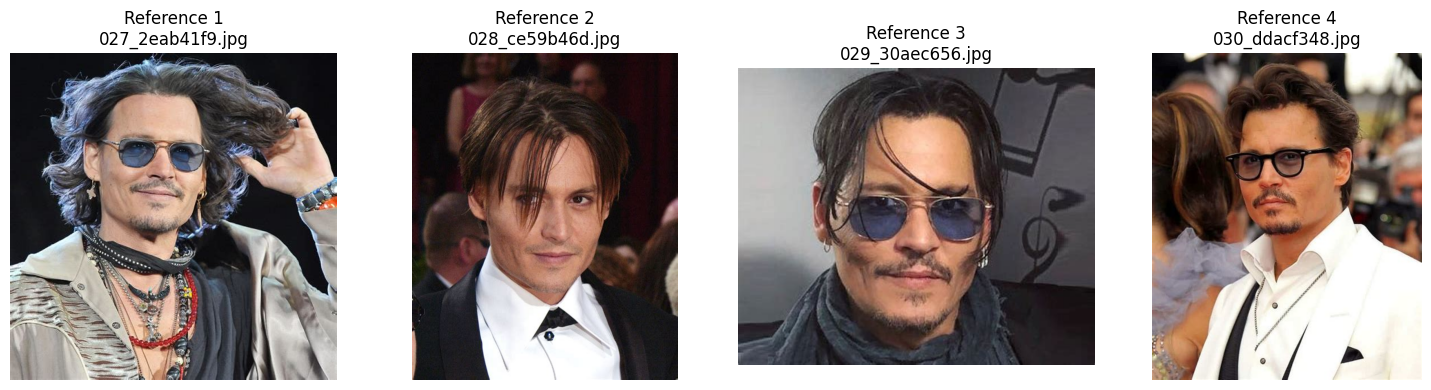

In [9]:
# ============================================================================
# CELL 5: LOAD REFERENCE IMAGES
# ============================================================================

# Load reference images
try:
    num_references = reference_manager.load_references(CONFIG['reference_folder'])
    print(f"\n✓ Loaded {num_references} reference images")
    
    # Display reference images
    if CONFIG['create_visualizations']:
        reference_manager.show_references()
        
except Exception as e:
    print(f"Error loading references: {e}")
    print("Please check your reference folder path and ensure it contains 3-4 images")

In [10]:
# ============================================================================
# CELL 6: SEARCH GALLERY
# ============================================================================

# Search gallery for matches
try:
    matches = searcher.search_gallery(
        gallery_folder=CONFIG['gallery_folder'],
        similarity_threshold=CONFIG['similarity_threshold'],
        max_matches=CONFIG['max_matches']
    )
    
    print(f"\n✓ Search complete: {len(matches)} matches found")
    
except Exception as e:
    print(f"Error during gallery search: {e}")
    matches = []

Searching gallery: ../datasets/images/face/gallery
Similarity threshold: 0.8
Found 130 images in gallery


Searching gallery:   0%|          | 0/130 [00:00<?, ?it/s]

✓ Found 40 matches

✓ Search complete: 40 matches found


Copying 40 matches to ../datasets/images/face/matched_images


Copying matches:   0%|          | 0/40 [00:00<?, ?it/s]

✓ Copied 40 matches successfully
✓ Report saved: ..\datasets\images\face\matched_images\analysis_metadata\analysis_report_20250611_114051.json

MATCH SUMMARY - 40 matches found


,Image,Similarity,Best_Reference,Output_File
0,030_ddacf348.jpg,1.000,030_ddacf348.jpg,030_ddacf348_sim1.000.jpg
1,029_30aec656.jpg,1.000,029_30aec656.jpg,029_30aec656_sim1.000.jpg
2,028_ce59b46d.jpg,1.000,028_ce59b46d.jpg,028_ce59b46d_sim1.000.jpg
3,027_2eab41f9.jpg,1.000,027_2eab41f9.jpg,027_2eab41f9_sim1.000.jpg
4,005_9406f32d.jpg,0.940,030_ddacf348.jpg,005_9406f32d_sim0.940.jpg
5,035_2a1b8bcf.jpg,0.912,030_ddacf348.jpg,035_2a1b8bcf_sim0.912.jpg
6,040_2e8934ea.jpg,0.896,030_ddacf348.jpg,040_2e8934ea_sim0.896.jpg
7,008_35d1be70.jpg,0.890,030_ddacf348.jpg,008_35d1be70_sim0.890.jpg
8,020_6b7d8470.jpg,0.883,027_2eab41f9.jpg,020_6b7d8470_sim0.883.jpg
9,039_13af66c8.jpg,0.876,027_2eab41f9.jpg,039_13af66c8_sim0.876.jpg



Top 5 Matches:


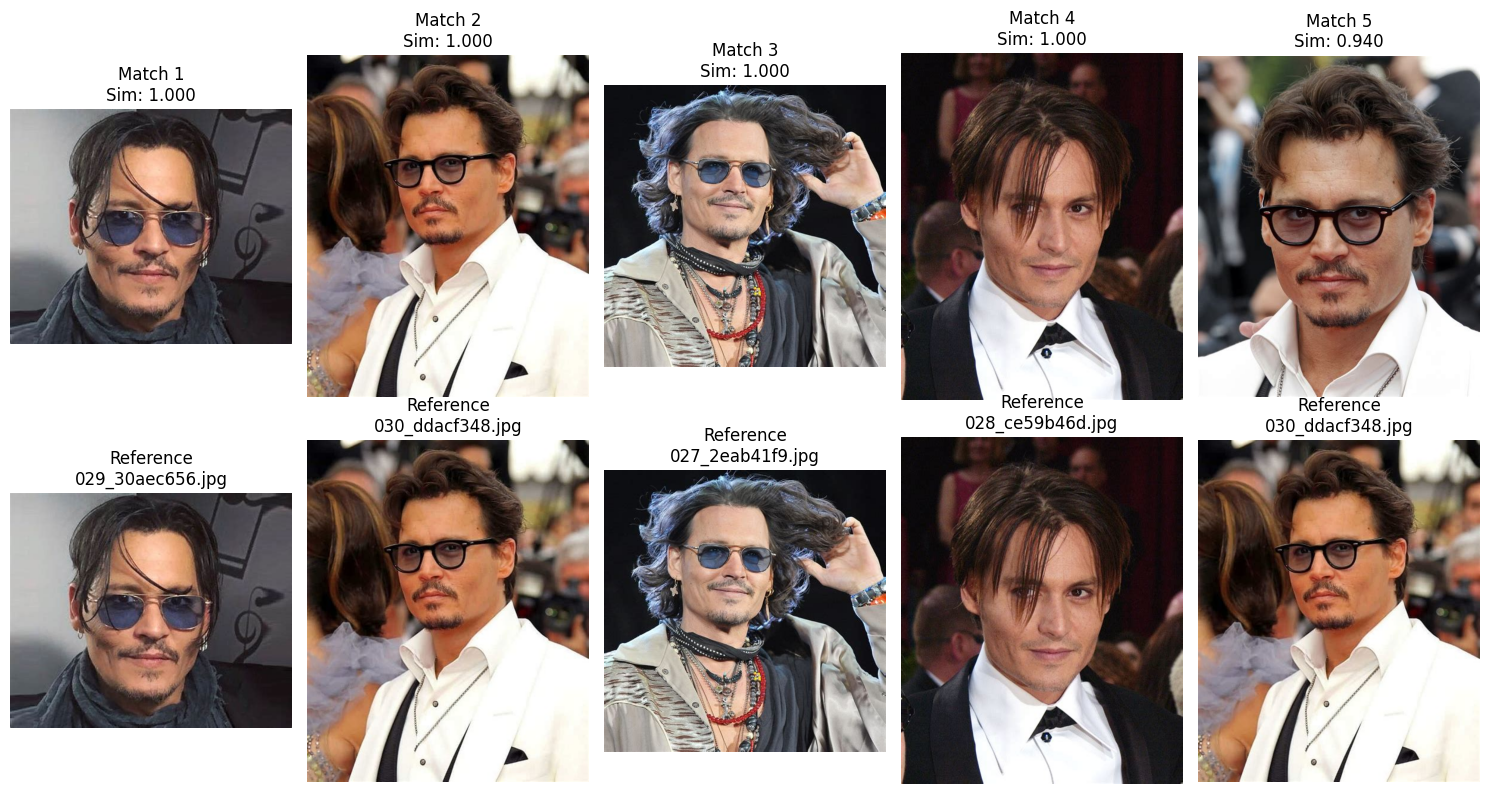


ANALYSIS COMPLETE
✓ 40 matches copied to: ../datasets/images/face/matched_images
✓ Report saved: ..\datasets\images\face\matched_images\analysis_metadata\analysis_report_20250611_114051.json


In [11]:
# ============================================================================
# CELL 7: PROCESS RESULTS
# ============================================================================

if matches:
    # Copy matches to output folder
    copied_matches = results_manager.copy_matches(matches, CONFIG['output_folder'])
    
    # Save analysis report
    report_file = results_manager.save_report(copied_matches, CONFIG['output_folder'], CONFIG)
    
    # Show results summary
    results_manager.show_matches_summary(copied_matches)
    
    # Show visualizations of top matches
    if CONFIG['create_visualizations']:
        results_manager.show_top_matches(copied_matches, top_n=5)
    
    print(f"\n{'='*60}")
    print("ANALYSIS COMPLETE")
    print(f"✓ {len(copied_matches)} matches copied to: {CONFIG['output_folder']}")
    print(f"✓ Report saved: {report_file}")
    print(f"{'='*60}")
    
else:
    print("\nNo matches found. Consider:")
    print("- Lowering similarity threshold")
    print("- Checking image quality")
    print("- Verifying gallery folder path")

In [12]:
# ============================================================================
# CELL 8: INTERACTIVE ANALYSIS (OPTIONAL)
# ============================================================================

def analyze_with_threshold(threshold):
    """Quick analysis with different threshold"""
    print(f"Analyzing with threshold: {threshold}")
    
    new_matches = searcher.search_gallery(
        gallery_folder=CONFIG['gallery_folder'],
        similarity_threshold=threshold,
        max_matches=20  # Limit for quick analysis
    )
    
    print(f"Found {len(new_matches)} matches with threshold {threshold}")
    
    if new_matches:
        # Quick summary
        similarities = [m['similarity_score'] for m in new_matches]
        print(f"Similarity range: {min(similarities):.3f} - {max(similarities):.3f}")
        
        # Show top 3
        if CONFIG['create_visualizations']:
            results_manager.show_top_matches(new_matches, top_n=3)
    
    return new_matches

# Example usage - uncomment to use:
# test_matches_high = analyze_with_threshold(0.80)  # High confidence
# test_matches_med = analyze_with_threshold(0.65)   # Medium confidence

print("\n" + "="*60)
print("NOTEBOOK SETUP COMPLETE")
print("="*60)
print("You can now:")
print("1. Modify CONFIG and re-run cells 5-7")
print("2. Use analyze_with_threshold() for quick tests")
print("3. Run individual components as needed")
print("="*60)


NOTEBOOK SETUP COMPLETE
You can now:
1. Modify CONFIG and re-run cells 5-7
2. Use analyze_with_threshold() for quick tests
3. Run individual components as needed
